Question 7
---
The formula for $\mu_{\mu}$ in terms of $I_{\mu}$ and $r_{uk}$ is $$\mu_{\mu}=\frac{\sum_{i\, \in\, I_{u}}^{} r_{ui}}{len(I_{u})}$$

Question 8
---
It means the set of item indices that both user u and v have rated.

Question 9
---
If one user will rate all items highly or poorly, then the absolute rates can not reflect the true rate for the items, and thus the relative rates matter in such case.

Question 10
---

load the data set from the file

In [1]:
import os
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate
from surprise import KNNWithMeans
import matplotlib.pyplot as plt
import numpy as np

file_path = os.path.expanduser('../ml-latest-small/ratings.csv')
reader = Reader(line_format = 'user item rating timestamp', sep = ',', skip_lines = 1)
data = Dataset.load_from_file(file_path, reader = reader)

The template for knn filter is as follows:

In [2]:
sim_options = {'name': 'pearson'}

def knn_coll_filter(data, sim_options = sim_options, cv = 10, x = range(2, 101, 2)):
    sim_options = sim_options
    avg_rmse = [0] * len(x)
    avg_mae = [0] * len(x)
    for k in x:
        algo = KNNWithMeans(k, sim_options = sim_options)
        a = cross_validate(algo, data, measures = ['RMSE', 'MAE'], cv = cv)
        test_rmse = a['test_rmse']
        test_mae = a['test_mae']
        avg_rmse[k / 2 - 1] = sum(test_rmse) / len(test_rmse)
        avg_mae[k / 2 - 1] = sum(test_mae) / len(test_mae)
        print k / 2 - 1
        print avg_rmse[k / 2 - 1]
        print avg_mae[k / 2 - 1]
    return x, avg_rmse, avg_mae

So for Question 10, we could just use the data from the *ratings.csv* and pass it into the `knn_coll_filter()`:

In [3]:
%%capture
x, avg_rmse, avg_mae = knn_coll_filter(data)

From the above, we can get the average RMSE, `avg_rmse` and the average MAE, `avg_mae`, and now we can plot using these data

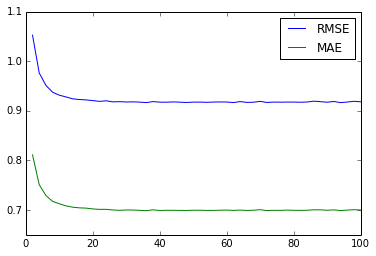

In [4]:
%matplotlib inline

plt.plot(x, avg_rmse, label='RMSE')
plt.plot(x, avg_mae, label='MAE')
plt.legend()
plt.show()

Question 11
---
Thus we can conclude from the plots that **the minimum k is 22**

Question 12
---

The templete for filtering the trimmed data

In [5]:
from surprise.model_selection import KFold
from surprise import accuracy

x = range(2, 101, 2)

# the trim function is used to process the testset
# by default the trim function don't do anything
def knn_filter_trim(trim = lambda x : x):
    n_splits = 10
    kf = KFold(n_splits = n_splits)
    rmse_list = []
    for k in x:
        rmse = 0
        algo = KNNWithMeans(k, sim_options = sim_options)
        for trainset, testset in kf.split(data):
            algo.fit(trainset)
            testset = trim(testset)
            prediction = algo.test(testset)
            rmse += accuracy.rmse(prediction)
        rmse_list.append(rmse / n_splits)
    return rmse_list

Using the template above, for Question 12-14 we could just write their corresponding *trim function* and use this to process the testset.

In [6]:
# the trim function for popular movie trimming
# delete the movie which has received less than or equal to 2 ratings
# each item in testset is represented by (userId, movieId, rating)
# this trim function can be used by Question 12 and 13
def trim(testset, trim_condition = lambda x : x <= 2):
    movie_map = dict()
    for i in testset:
        movie = i[1]
        movie_map[movie] = 1 if (movie not in movie_map) else movie_map[movie] + 1
    for movie_id in movie_map:
        # meaning that this item should be trimmed
        if trim_condition(movie_map[movie_id]):
            testset = filter(lambda x: x[1] != movie_id, testset)
    return testset

In [7]:
%%capture

def trim_popular(testset):
    return trim(testset)
rmse_popular_list = knn_filter_trim(trim_popular)

And we can use the `rmse_popular_list` to evaluate the performance on the trimmed popular movie set.

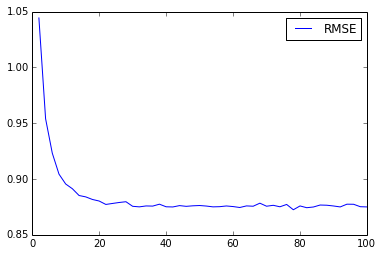

In [8]:
plt.plot(x, rmse_popular_list, label='RMSE')
plt.legend()
plt.show()

Question 13
---
The difference between Question 12 and Question 13 is just the parameter `trim_condition` in the `trim()`

In [9]:
%%capture

def trim_unpopular(testset):
    return trim(testset, trim_condition = lambda x : x > 2)

rmse_unpopular_list = knn_filter_trim(trim_unpopular)

And we can use the `rmse_unpopular_list` to evaluate the performance on the trimmed unpopular movie set.

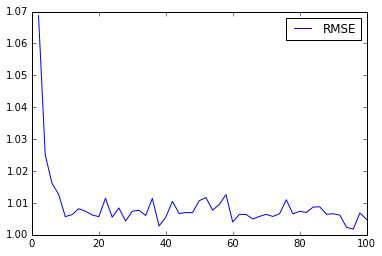

In [10]:
plt.plot(x, rmse_unpopular_list, label='RMSE')
plt.legend()
plt.show()

Question 14
---

In [11]:
def trim_high_variance(testset):
    movie_map = dict()
    for (user, movie, rate) in testset:
        if (movie in movie_map):
            movie_map[movie].append(rate)
        else:
            movie_map[movie] = [rate]
    for movie_id in movie_map:
        rating = movie_map[movie_id]
        if len(rating) < 5 or np.var(np.array(rating)) < 2:
            testset = filter(lambda x: x[1] != movie_id, testset)
    return testset 

And the trimming for the high variance movie trimmed test set can be implemented by the above method.

In [12]:
%%capture

rmse_high_variance_list = knn_filter_trim(trim_high_variance)

The plot of the rmse_unpopular_list is as follows:

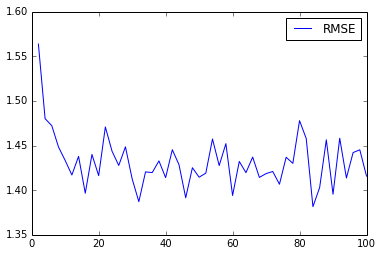

In [13]:
%matplotlib inline

plt.plot(x, rmse_high_variance_list, label='RMSE')
plt.legend()
plt.show()

Question 15
---

Computing the pearson similarity matrix...
Done computing similarity matrix.


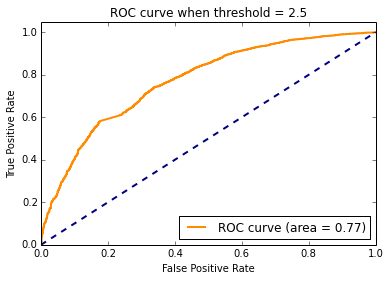

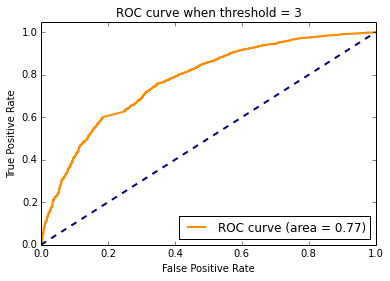

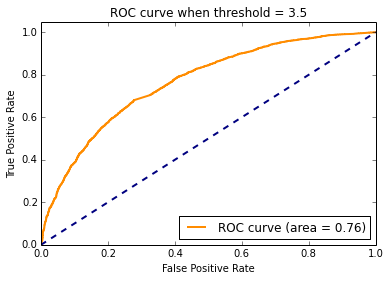

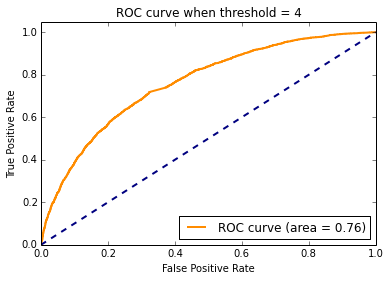

In [14]:
from surprise.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

thresholds = [2.5, 3, 3.5, 4]
k = 22
sim_options = {'name': 'pearson'}

trainset, testset = train_test_split(data, test_size = 0.1)
algo = KNNWithMeans(k, sim_options = sim_options)
algo.fit(trainset)
predictions = algo.test(testset)

label_true = [x[2] for x in predictions]
label_esti = [x[3] for x in predictions]

for threshold in thresholds:
    binary_true = map(lambda x : 0 if x < threshold else 1, label_true)
    fpr, tpr, _ = roc_curve(binary_true, label_esti)
    roc_auc = auc(fpr,tpr)
    
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve when threshold = ' + str(threshold))
    plt.legend(loc="lower right")
    plt.show()